In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
from resnet import Resnet4Channel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import scipy.optimize as opt

In [3]:
np.random.seed(21)

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


### get better validation split since the classes are very unevenly represented

In [6]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_df_orig = df.copy()

train_df_orig['Target'] = train_df_orig.apply(lambda x: x['Target'].split(' '), axis=1)

X = train_df_orig['Id'].tolist()
y = train_df_orig['Target'].tolist()
y = MultiLabelBinarizer().fit_transform(y)

for train_index, val_index in msss.split(X,y): #it should only do one iteration
    print("Train:", train_index, "Valid:", val_index)

del X, y
gc.collect()

len(train_index), len(val_index), len(df)

Train: [    0     1     2     3 ... 31067 31069 31070 31071] Valid: [    9    40    55    67 ... 31044 31046 31059 31068]


(27958, 3114, 31072)

### set everything we need for creating a ImageMultiDataset

In [7]:
fns = pd.Series([id + '.png' for id in df.Id])
labels = [targ.split(' ') for targ in df.Target]
classes=[str(i) for i in range(28)]

In [8]:
trn_mask=[]

for i in range(len(df)):
    trn_mask.append(False if i in val_index else True)
    
len(trn_mask), trn_mask.count(True), trn_mask.count(False)

(31072, 27958, 3114)

### create train, valid and test ImageMultiDataset

In [15]:
trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)
trn_ds, val_ds

(ImageMulti4Channel of len 27958, ImageMulti4Channel of len 3114)

In [16]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [17]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 'test', pd.Series(test_ids),[['0'] for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

### define transforms, normalization and metric

In [12]:
get_transforms

<function fastai.vision.transform.get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]>

In [13]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1,
                      max_lighting=0.2, max_warp=0.2)

In [14]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

### create ImageDataBunch from all this

In [15]:
torch.backends.cudnn.benchmark = True
src_size = 512

In [16]:
bs = 8 #64

In [17]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=224).normalize(protein_stats)

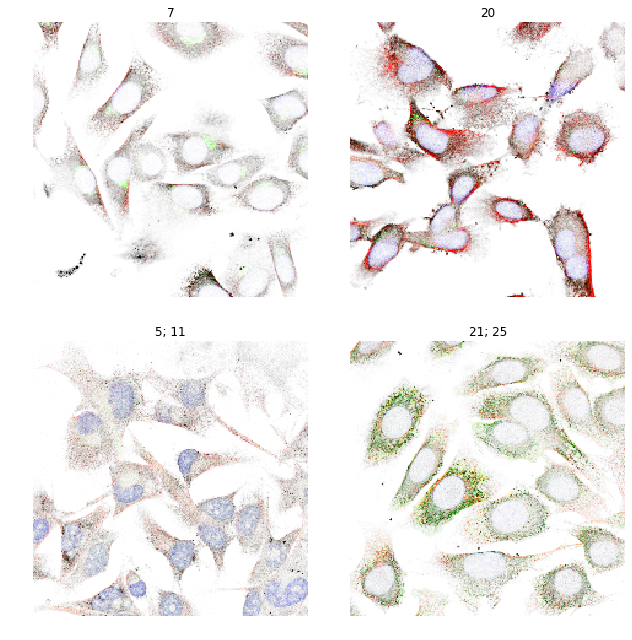

In [18]:
data.show_batch(rows=2, figsize=(9,9), ds_type=DatasetType.Valid)

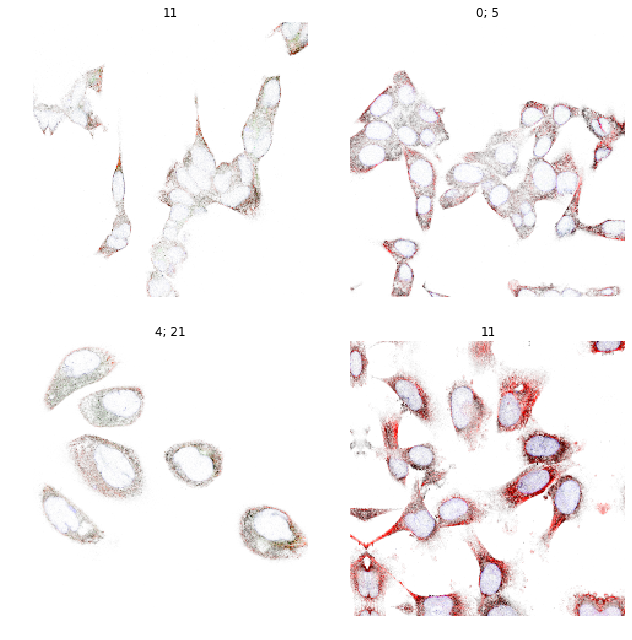

In [19]:
data.show_batch(rows=2, figsize=(9,9))

### create model and learner

In [20]:
def resnet34(pretrained=True):
    return Resnet4Channel(encoder_depth=34, pretrained=pretrained)

def resnet50(pretrained=True):
    return Resnet4Channel(encoder_depth=50, pretrained=pretrained)

def resnet152(pretrained=True):
    return Resnet4Channel(encoder_depth=152, pretrained=pretrained)

In [21]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [22]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

#for loss weights: .to(torch.device("cuda"))

In [23]:
f1 = partial(fbeta, thresh=0.4, beta=1) #thresh=weights

In [24]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [25]:
#bce_logit_loss = partial(F.binary_cross_entropy_with_logits, pos_weight=weights)

In [26]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [27]:
learn = create_cnn(
    data,
    resnet152,
    ps=0.5,
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc], 
)

In [28]:
learn.loss_func = FocalLoss()

In [29]:
learn.loss_func, learn.opt_func

(FocalLoss(),
 functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)))

In [30]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [31]:
learn.freeze()

In [32]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

### use lr find to get a good learning rate

In [33]:
learn.data.train_ds, learn.data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 27958),
 DatasetTfm(ImageMulti4Channel of len 3114))

In [35]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


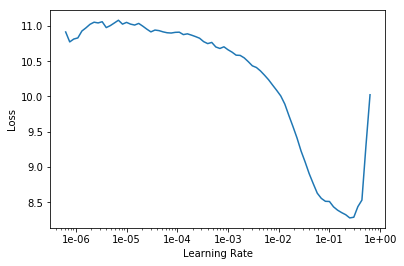

In [36]:
learn.recorder.plot() 

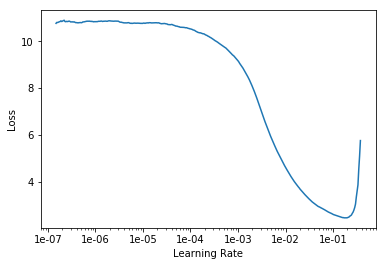

In [55]:
learn.recorder.plot() 

In [34]:
lr = 2e-3

### fit the model (half image size)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(lr))

epoch,train_loss,valid_loss,fbeta,acc


In [ ]:
learn.save('halfsz_focal_res152_e1')

### unfreeze there resnet layers and train again 

In [31]:
learn.load('halfsz_focal_res152_e1')

In [32]:
learn.unfreeze()

In [33]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


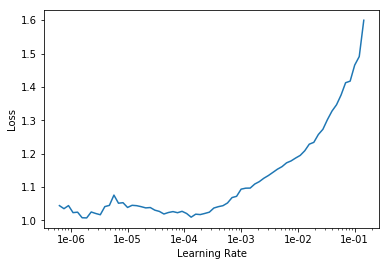

In [34]:
learn.recorder.plot() #resnet152

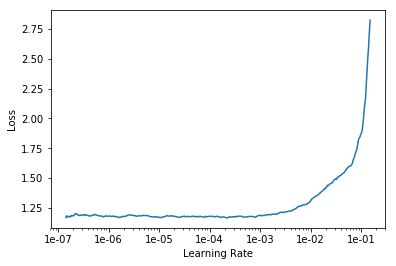

In [38]:
learn.recorder.plot() #resnet50

In [45]:
lr = 2e-3

In [46]:
lrs = slice(lr/9, lr/2) 

In [47]:
learn.lr_range(lrs)

array([0.000222, 0.000471, 0.001   ])

In [42]:
learn.fit_one_cycle(10, max_lr=lrs)

Total time: 44:50
epoch  train_loss  valid_loss  fbeta  acc        
1      1.011791    0.919809    0.576366  0.958689  (04:41)
2      0.925945    0.867240    0.617516  0.960444  (04:36)
3      0.870490    0.894683    0.605141  0.960031  (04:35)
4      0.828892    0.782568    0.650501  0.963414  (04:41)
5      0.765755    0.764532    0.664020  0.964022  (04:32)
6      0.729458    0.700552    0.690317  0.966121  (04:20)
7      0.680651    0.640930    0.719164  0.969343  (04:20)
8      0.625752    0.610901    0.734401  0.970949  (04:20)
9      0.599784    0.597751    0.742239  0.971534  (04:20)
10     0.593079    0.594364    0.739993  0.971591  (04:20)



### train on whole picture (512px)

In [37]:
bs = 12

In [38]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(protein_stats)

In [39]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    path=path,    
    metrics=[f1,acc], 
)

In [40]:
learn.loss_func = FocalLoss()

In [41]:
learn.split(split_on=_resnet_split)

In [42]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [38]:
learn.freeze()

In [42]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

In [43]:
learn.load('halfsz_focal_res152_e10')

In [43]:
learn.lr_find()

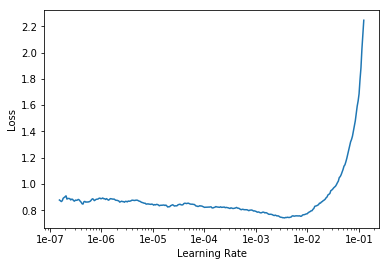

In [58]:
learn.recorder.plot()

In [46]:
lr = 1e-3

In [44]:
learn.fit_one_cycle(1, max_lr=slice(lr))

Total time: 06:58
epoch  train_loss  valid_loss  fbeta  acc        
1      0.704762    0.696564    0.688741  0.966889  (06:58)



In [45]:
learn.save('fullsz_focal_res152_e1')

In [60]:
learn.load('halfsz_focal_res152_e10')

In [61]:
learn.unfreeze()

In [48]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


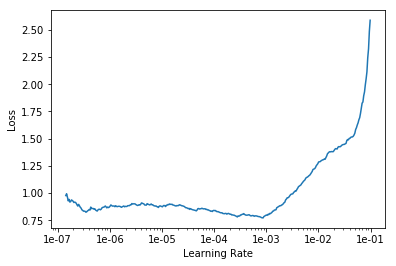

In [49]:
learn.recorder.plot() #resnet50 without frozen training

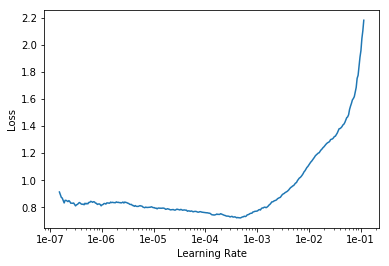

In [60]:
learn.recorder.plot() #resnet34 without frozen training

In [40]:
lr_fine = lr/10
lrs = slice(lr_fine/2, lr_fine)

In [41]:
learn.lr_range(lrs)

array([0.0001  , 0.000141, 0.0002  ])

In [52]:
learn.fit_one_cycle(30, lrs) #lr/20, lr/10 resnet50

Total time: 8:41:23
epoch  train_loss  valid_loss  fbeta  acc        
1      0.660707    0.662754    0.702907  0.968598  (17:30)
2      0.658712    0.621468    0.719857  0.970399  (17:24)
3      0.631526    0.601416    0.730012  0.971190  (17:20)
4      0.644306    0.592997    0.741107  0.972004  (17:22)
5      0.655353    0.597178    0.739216  0.971087  (17:22)
6      0.618391    0.584602    0.740991  0.971959  (17:22)
7      0.620989    0.593008    0.734230  0.971752  (17:22)
8      0.616385    0.586004    0.745648  0.972394  (17:22)
9      0.612414    0.591006    0.737570  0.972463  (17:22)
10     0.645932    0.589050    0.743536  0.972337  (17:22)
11     0.627647    0.588514    0.744913  0.971637  (17:22)
12     0.570436    0.573974    0.744113  0.973082  (17:22)
13     0.602325    0.575472    0.750654  0.973117  (17:21)
14     0.572829    0.565462    0.755961  0.973874  (17:22)
15     0.585624    0.561532    0.756438  0.973667  (17:22)
16     0.538708    0.550453    0.758691  0.97

In [53]:
learn.save('fullsz_focal_res50_unfrozen_e30')

### Try to find a good Threshold

In [43]:
learn.load('fullsz_focal_res152_unfrozen_e30')

In [44]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [45]:
preds, y = learn.get_preds(DatasetType.Valid)

In [46]:
preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)

Total time: 05:50



In [47]:
preds.shape, preds_tta.shape

(torch.Size([3114, 28]), torch.Size([3114, 28]))

In [48]:
#m = nn.Softmax(dim=1)
#act_preds = m(preds)

In [72]:
#act_preds = np.exp(preds)

In [50]:
act_preds = torch.sigmoid(preds)

act_preds_tta = torch.sigmoid(preds_tta)

In [51]:
#np.set_printoptions(suppress=True)

In [52]:
act_preds[0].round(), y[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [53]:
act_preds.shape, act_preds_tta.shape

(torch.Size([3114, 28]), torch.Size([3114, 28]))

In [471]:
ensamble = act_preds * 0.1 + act_preds_tta * 0.9

In [510]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [477]:
fbeta(ensamble, y, thresh=0.34, sigmoid=False) #compare

tensor(0.8251)

In [478]:
fbeta(ensamble, y, thresh=0.33, sigmoid=False)

tensor(0.8243)

### predict test set 

In [88]:
preds_t,y_t = learn.get_preds(DatasetType.Test)

In [89]:
preds_t_tta,y_t = learn.TTA(ds_type=DatasetType.Test)

Total time: 19:02



In [90]:
#m = nn.Softmax(dim=1)
#act_preds_t = m(preds_t)

In [91]:
#act_preds_t = np.exp(preds_t)

In [207]:
act_preds_t = torch.sigmoid(preds_t)

act_preds_t_tta = torch.sigmoid(preds_t_tta)

In [208]:
act_preds_t[0].round(), act_preds_t_tta[0].round()

(tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [209]:
act_preds_t.shape, act_preds_t_tta.shape

(torch.Size([11702, 28]), torch.Size([11702, 28]))

In [210]:
tuned_weights = weights*0.92
tuned_weights

tensor([0.4600, 0.3680, 0.3680, 0.3680, 0.3680, 0.3680, 0.3680, 0.3680, 0.1840,
        0.1840, 0.1840, 0.3680, 0.3680, 0.3680, 0.3680, 0.1840, 0.3680, 0.3680,
        0.3680, 0.3680, 0.1840, 0.3680, 0.3680, 0.3680, 0.3680, 0.3680, 0.3680,
        0.1840])

In [211]:
ensamble_t = act_preds_t * 0.1 + act_preds_t_tta * 0.9

In [212]:
#preact_preds_td_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.318)[0]])) \
#               for row in np.array(act_preds_t)]

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>(tuned_weights).numpy())[0]])) \
               for row in np.array(ensamble_t)]

In [213]:
sub = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})

In [214]:
len(sub['Predicted'][sub['Predicted']==''])

127

In [215]:
unique_target = df.groupby('Target')['Id'].nunique()

In [216]:
unique_target[unique_target>1000]

Target
0       2414
21      1058
23      1653
25      1470
25 0    1998
4       1077
7       1163
Name: Id, dtype: int64

In [217]:
sub['Predicted'][sub['Predicted']==''] = '0'

In [218]:
sub.to_csv(path/'resnet50.csv', header=True, index=False)

In [219]:
pred_labels

['2',
 '5 25',
 '0 5 25',
 '0 25',
 '25',
 '4 21',
 '0 4 21 25',
 '0 25',
 '0',
 '21 25',
 '25',
 '3 5',
 '2 25',
 '7',
 '21 23 25',
 '18 25',
 '2 25',
 '0 5',
 '14 21',
 '0 5',
 '6 25',
 '2 25',
 '0 25',
 '21',
 '0 4 25',
 '23 25',
 '',
 '0',
 '0 25',
 '5',
 '21',
 '0 19',
 '17 18',
 '5 25',
 '0 7 25',
 '13',
 '25',
 '3',
 '11',
 '1',
 '0 25',
 '6',
 '0 21 25',
 '19 25',
 '25',
 '6',
 '0',
 '0',
 '6',
 '0',
 '16 25',
 '0 5',
 '20 23',
 '25',
 '3',
 '0 21 25',
 '0 25',
 '11 25',
 '0 25',
 '21 25',
 '2 20',
 '0 5 21 25',
 '14 25',
 '21 25',
 '23',
 '0 25',
 '3 21 25',
 '25',
 '0 20',
 '',
 '2',
 '0 2',
 '14',
 '4',
 '21',
 '0',
 '0 4',
 '0 1',
 '0 25',
 '0 25',
 '25',
 '0 25',
 '21',
 '21 25',
 '18',
 '0 25',
 '23',
 '0 21',
 '25',
 '14 25',
 '0 25',
 '21',
 '23',
 '13',
 '23 25',
 '0 25',
 '25',
 '0 7 25',
 '24',
 '23 25',
 '1 25',
 '23',
 '23',
 '0 23',
 '7',
 '21 25',
 '0 14',
 '0 11',
 '20 26',
 '0 25',
 '2 25',
 '1',
 '16 17 25',
 '0 21 22 25',
 '25',
 '21 23 25',
 '0',
 '4 25',
 '